<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [137]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [138]:
# Load the data
file = './housing.csv'
df = pd.read_csv(file) 

In [139]:
# %load eda
import os

# file = './xxx.csv'
#pd.read_csv(file)
# os.chdir('C:/Users/schen24/dropbox/Coding/')
# %load eda

import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

def edamain(df):
    pd.set_option('display.max_columns', 100)
    dtypes = pd.Series(df.dtypes)
    dfsample = pd.concat([dtypes,df.sample(10).T], axis=1)

    print(df.info(),'\n')
    print(df.head())
    #print(df.describe(),'\n')
    print('**Sample of 10** \n', dfsample)
    print('\n', df.columns)
def setindex(df, col):
    df.set_index(col)
def dropcol(df, col):
    df.drop(col, axis=1, inplace=True)
    # drop rows easily
    #df = df[~df.gender.isin([0,3])]
def misc():
# dropping columns containing certain strings
    df.drop(list(df.filter(regex = 'worst')), axis = 1, inplace = True)
# replacing values based on criteria
    df['Exterior1st'] = np.where(df['Exterior1st'].isin(other), 'Other', df['Exterior1st'])
# selecting a certain datatype
    df.select_dtypes(include='number')
def zeroes(df, percentage):
    zi = (df[df == 0].count(axis=1)/len(df.columns)).sort_values(ascending=False)
    zc = (df[df == 0].count(axis=0)/len(df.index)).sort_values(ascending=False)
    print(zi[zi > percentage], '\n',len(zi))
    print(zc[zc > percentage], '\n',len(zc))
def dropna(df, *args):
    #write code to identify NAs
    na_list = (df.isnull().sum()/len(df.index)).sort_values(ascending=False)
    print('% NAs per column')
    print(na_list[na_list !=0])
    #show most NAs per row/column
def dropna2(df, *args):
    no = int(input('show more than how many NAs per row?'))
    print(df[df.isnull().sum(axis=1) >= no])
    #now drop
    droptype = int(input('1. drop NAs specific R/C, and/or \n2. universal dropNAs R/C\n \
    \n3. exit \n'))
    if droptype ==1:
        collist = str(input('input cols, separated by space'))
        collist = collist.split()
        numbernas = int(input('input minimum NAs per row:' )) or None
        df.dropna(subset=collist, thresh = numbernas, inplace=True)
    elif droptype==2:
        axis = int(input("drop by col [1] or row [0] ? " )) or 0
        numbernas = int(input("minimum NAs to drop R/C? (length {}) ".format([len(df.columns) if axis ==0 else len(df.index)]))) or None
        df.dropna(axis=axis, thresh= numbernas, inplace=True)
    else:
        exit()
#str replacement
def strrep(df, chars):
    chars = '['+chars+']'
    df.select_dtypes(include=[object]).apply(lambda x: x.str.replace(chars, ''))
#correlation of independent variables to target variable only
def simplecorr(df, target):
    # correlation against the y variable
    sns.heatmap(df.corr()[[target]].sort_values(by=target, ascending=False), annot=True)
#changing datatypes
def coltype(df, col, type):
    whattype = input('converting to date? (Y or N)')
    if whattype =='Y':
        print('%d, %b, %B, %m =mth (m num), %y%Y')
        df[col] =  pd.to_datetime(df[col], format=type)
        print(df.dtypes)
    else:
        df[col]=df[col].astype(type)
        print(df.dtypes)
def makedummies(df, col):
    dummy = pd.get_dummies(df[col], prefix=col, drop_first=True)
    df = pd.concat([df, dummy], axis=1)
    dropcol(df, col)
    return df
edamain(df)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [140]:
# remove non-residential houses
df = df[df.MSZoning != 'C (all)']

In [141]:
# drop ID - nothing special 
dropcol(df, ['Id'])

In [142]:
# drop housestyle and buildingtype because it is a duplicate of MS Subclass
dropcol(df, ['HouseStyle', 'BldgType'])

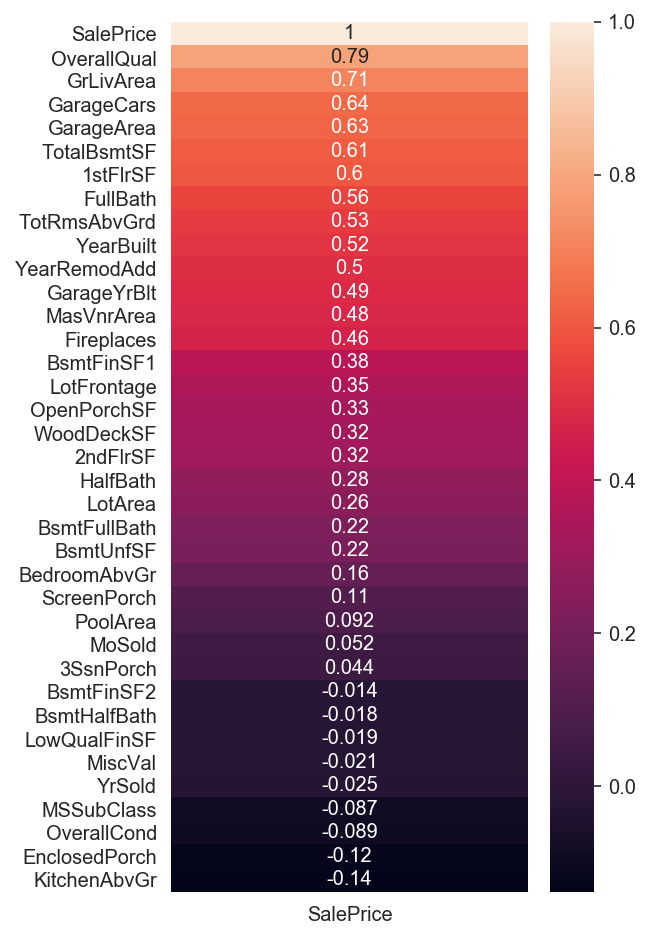

In [143]:
# quick look at top correlations
plt.subplots(figsize=(4,8))
simplecorr(df, 'SalePrice')

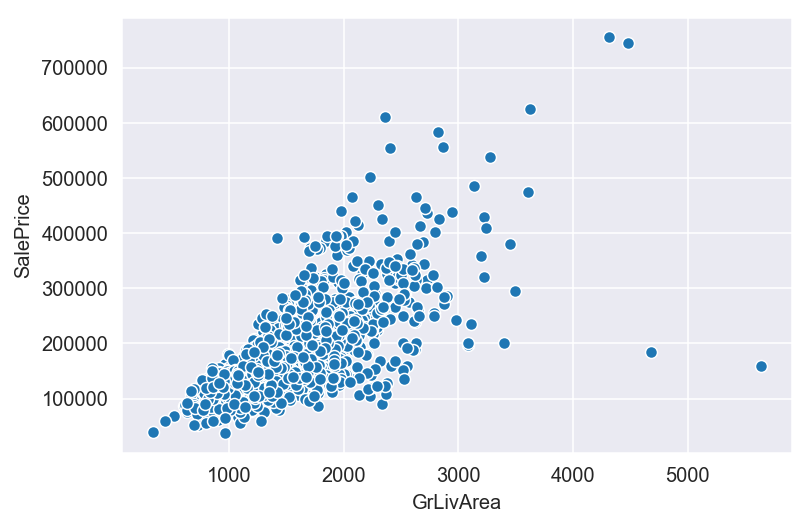

In [144]:
# doing a quick scatterplot of highest correlated variable 
sns.scatterplot(df.GrLivArea, df.SalePrice)

In [145]:
# remove 2 outliers on lower right which are so large that they were sold cheaply. 
df = df[~((df.GrLivArea >4000) & (df.SalePrice <200000))]

Numbered variables

In [146]:
df.select_dtypes(include='number').sample(10)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
272,60,92.0,11764,8,7,1999,2007,348.0,524,0,628,1152,1164,1106,0,2270,0,0,2,1,4,1,9,1,1999.0,3,671,132,57,0,0,0,0,0,4,2010,290000
20,60,101.0,14215,8,5,2005,2006,380.0,0,0,1158,1158,1158,1218,0,2376,0,0,3,1,4,1,9,1,2005.0,3,853,240,154,0,0,0,0,0,11,2006,325300
532,20,60.0,7200,5,7,1955,2007,0.0,0,0,0,0,827,0,0,827,0,0,1,0,2,1,5,1,1967.0,1,392,0,0,0,0,0,0,0,4,2010,107500
270,60,84.0,10728,8,5,2006,2006,0.0,0,0,1095,1095,1095,844,0,1939,0,0,2,1,3,1,8,1,2006.0,3,1053,192,51,0,0,0,0,0,8,2006,266000
784,75,35.0,6300,6,6,1914,2001,0.0,0,0,742,742,742,742,0,1484,0,0,2,0,3,1,9,1,NaN,0,0,0,291,134,0,0,0,0,6,2008,128000
171,20,141.0,31770,6,5,1960,1960,112.0,639,0,441,1080,1656,0,0,1656,1,0,1,0,3,1,7,2,1960.0,2,528,210,62,0,0,0,0,0,5,2010,215000
806,80,75.0,9750,5,5,1967,1967,0.0,400,480,100,980,980,0,0,980,0,0,2,0,3,1,6,0,1967.0,1,384,68,0,0,0,0,0,0,10,2006,135500
199,20,76.0,9591,8,5,2004,2005,262.0,1088,0,625,1713,1713,0,0,1713,1,0,2,0,3,1,7,1,2004.0,3,856,0,26,0,0,170,0,0,1,2009,274900
1045,20,NaN,13680,3,5,1955,1955,0.0,0,0,0,0,1733,0,0,1733,0,0,2,0,4,1,8,1,1955.0,2,452,0,0,0,0,0,0,0,6,2009,139600
501,60,75.0,9803,7,5,2005,2005,0.0,400,0,466,866,866,902,0,1768,0,0,2,1,3,1,7,0,2005.0,2,603,0,108,0,0,0,0,0,2,2008,226700


In [147]:
# MS subclass is in fact categorical variable.
# Create variables to combine various categories: 1-2 story = Sone, 2-3 story = Stwo, split/multi = Multi
# dup + 2famconv = Dup

In [148]:
df.MSSubClass = df.MSSubClass.map({20: 'Sone', 30:'Sone', 40:'Sone', 45:'Sone', 50:'Sone', 60:'Stwo', 70:'Stwo',\
                                  75:'Stwo', 80: 'Multi', 85: 'Multi', 90: 'Dup', 120: 'Sone', 150: 'Sone',\
                                  160: 'Stwo', 180:'Multi', 190:'Dup'})

In [149]:
# investigate lot frontage
df.LotFrontage.isnull().sum()


259

In [150]:
# 0 lot frontage?
df[df.LotFrontage==0].LotFrontage.count()

0

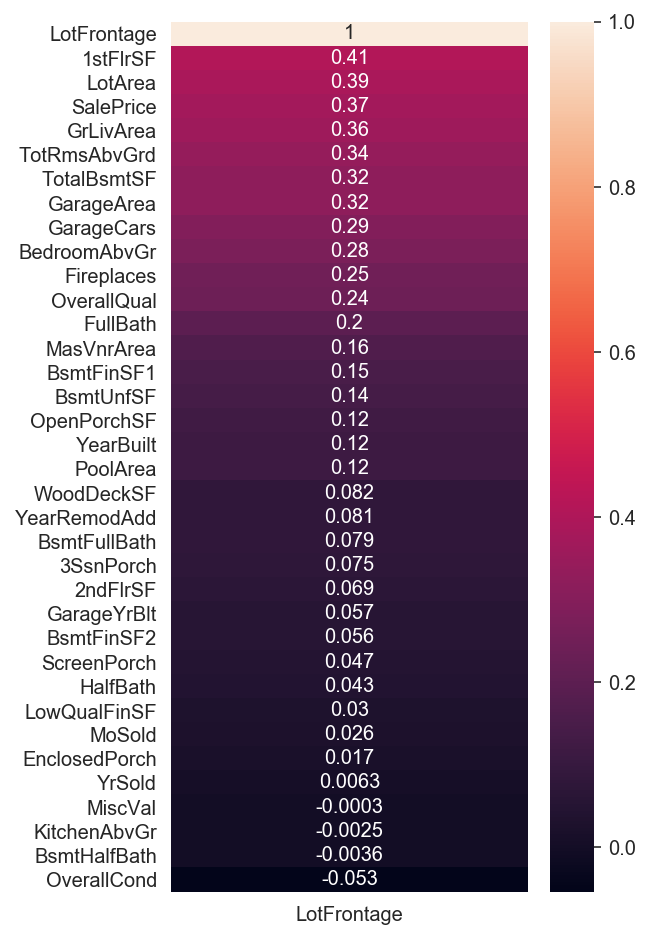

In [151]:
# which variable is most closely related to lot frontage?
plt.subplots(figsize=(4,8))
simplecorr(df, 'LotFrontage')

C:\Users\schen24\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


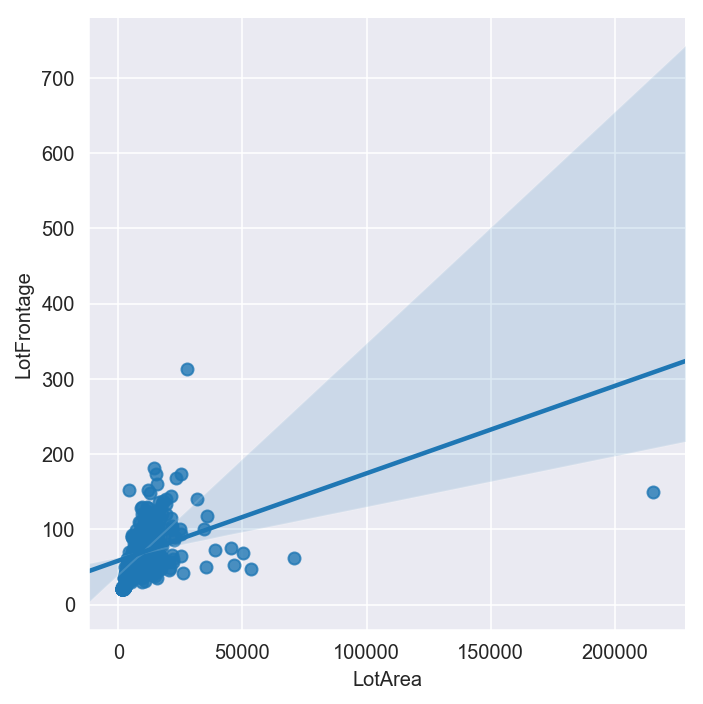

In [152]:
sns.lmplot('LotArea','LotFrontage',df, fit_reg=True)

In [153]:
# eyeballing line of best fit, intercept = 50, slope = 200/150000 = 0.0013333333333333333
# therefroe y = 0.001333 * x + 50
df.LotFrontage.fillna(50+ 0.001333*df.LotArea, inplace=True)

C:\Users\schen24\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\schen24\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\schen24\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


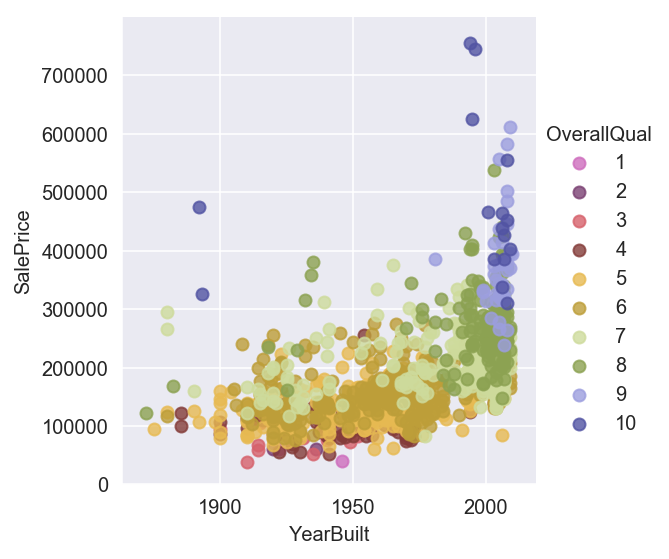

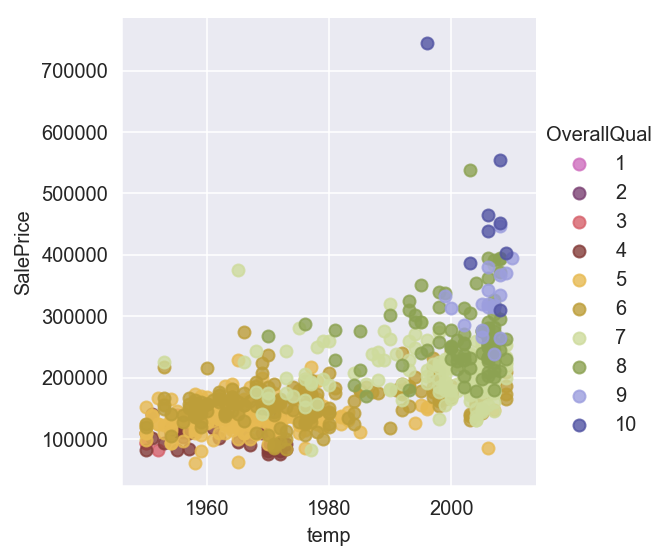

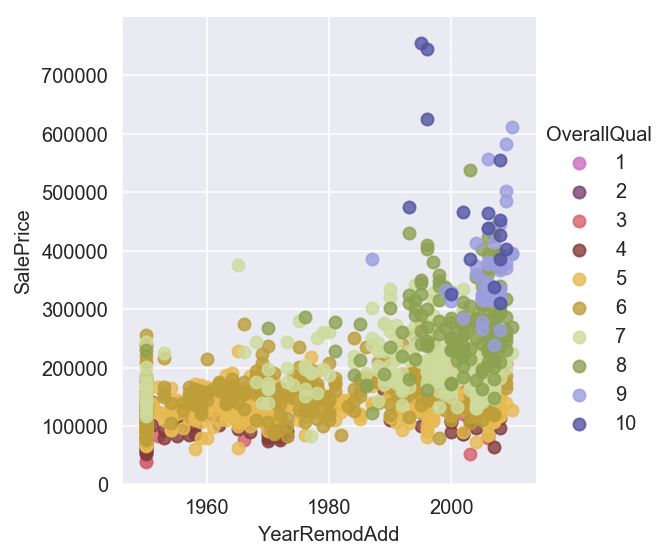

In [154]:
#investigate relationship between quality of house and year built / year remodeled
df['temp'] = np.where(df['YearBuilt']==df['YearRemodAdd'], df['YearBuilt'], np.nan)
sns.lmplot(x = 'YearBuilt', y = 'SalePrice', data = df, hue = 'OverallQual', \
           size = 4, fit_reg = False, palette = 'tab20b_r')
sns.lmplot(x = 'temp', y = 'SalePrice', data = df, hue = 'OverallQual', \
           size = 4, fit_reg = False, palette = 'tab20b_r')
sns.lmplot(x = 'YearRemodAdd', y = 'SalePrice', data = df, hue = 'OverallQual', \
           size = 4, fit_reg = False, palette = 'tab20b_r')

In [155]:
#there is a clear relationship between the sale price and recently built or recently remodeled houses, therefore
# best metric to use is 'year remodeled' because if house was not remodeled, year built is filled in instead. 
dropcol(df,['YearBuilt', 'temp'])

In [156]:
# bsmtqual renamed to bsmtheight as more accurate
df.rename(columns={'BsmtQual' : 'BsmtHeight'},inplace=True)

In [157]:
# reduce overlapping features
df[['1stFlrSF','2ndFlrSF','GrLivArea']].sample(10)

,1stFlrSF,2ndFlrSF,GrLivArea
1033,1654,0,1654
399,1112,438,1550
1177,818,406,1224
886,1712,0,1712
1372,1108,989,2097
896,951,0,951
815,1661,0,1661
211,1212,0,1212
689,1362,0,1362
1137,780,240,1020


In [158]:
# looks like 'grlivarea' is sum of 1st and 2nd flr sf. therefore remove former 2 as some houses have no 2nd floor
dropcol(df, ['1stFlrSF','2ndFlrSF'])

In [159]:
df[['GrLivArea', 'TotRmsAbvGrd', 'BedroomAbvGr','KitchenAbvGr', 'HalfBath', 'FullBath' ]].sample(10)

,GrLivArea,TotRmsAbvGrd,BedroomAbvGr,KitchenAbvGr,HalfBath,FullBath
1008,1710,7,3,1,0,2
112,2696,10,4,1,1,2
1106,1442,6,3,1,0,2
239,1487,7,3,1,1,1
1036,1620,6,2,1,0,2
477,2643,9,3,1,1,2
1257,864,4,2,1,0,1
1017,1360,4,1,1,0,1
730,1616,5,2,1,0,2
560,1392,5,3,1,1,1


In [160]:
#it's unclear what totrmsabvgrd include, but comparing the sq feet of living area, the other rooms cannot be that large 
# and are possibly laundry rooms, pantries, small studies etc. therefore we will drop totrmsabvgrd. 
dropcol(df, 'TotRmsAbvGrd')

In [161]:
#googling also revealed that total baths are calculated by awarding halfbath a decimal (0.1) for every integer (1) of a
#full bath
df['TotBathAbvGr'] = df['FullBath']+ df['HalfBath']/10
df['BsmtTotBath'] = df['BsmtFullBath']+ df['BsmtHalfBath']/10

In [162]:
#now drop 'fullbath' and 'halfbath'
dropcol(df, ['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath'])

In [163]:
#isolate basement features for investigation
basement = ['TotalBsmtSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','BsmtTotBath', 'SalePrice']
df[basement].sample(10)

,TotalBsmtSF,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,BsmtTotBath,SalePrice
178,2216,1904,0,312,1.0,501837
514,768,0,0,768,0.0,96500
393,788,266,0,522,0.0,100000
271,1385,226,1063,96,1.0,241500
752,1479,1200,0,279,1.0,217000
601,780,0,0,780,0.0,141000
105,1053,0,0,1053,0.0,250000
10,1040,906,0,134,1.0,129500
333,1358,720,0,638,1.0,207000
640,1518,1218,0,300,0.0,274000


In [164]:
df[basement].corr()[['SalePrice']].sort_values(by='SalePrice',ascending=False)

,SalePrice
SalePrice,1.000000
TotalBsmtSF,0.649844
BsmtFinSF1,0.407573
BsmtTotBath,0.225900
BsmtUnfSF,0.216136
BsmtFinSF2,-0.014193


In [165]:
#combine finished basement square feet
df['BsmtFinSF'] = df['BsmtFinSF1']+ df['BsmtFinSF2']
dropcol(df,['BsmtFinSF1', 'BsmtFinSF2'] )
basement = ['TotalBsmtSF', 'BsmtFinSF', 'BsmtUnfSF','BsmtTotBath', 'SalePrice']

In [166]:
# rerun correlation
df[basement].corr()[['SalePrice']].sort_values(by='SalePrice',ascending=False)

,SalePrice
SalePrice,1.000000
TotalBsmtSF,0.649844
BsmtFinSF,0.383229
BsmtTotBath,0.225900
BsmtUnfSF,0.216136


In [167]:
# it seems total basement sq feet has a higher corr to sale price than component parts
# therefore to avoid multicoll, remove unfinished and finished portions from dataset.
dropcol(df, ['BsmtFinSF', 'BsmtUnfSF'])

In [168]:
# month sold is numbered, but should be categorical. further group into seasons, because iowa has 4 distinct seasons
# and house sales can depend on weather. spring = 3,4,5 ; summer: 6,7,8 ; autumn : 9,10,11 ; winter : 12,1,2
df.MoSold = df.MoSold.map({6: 'summer', 7:'summer', 8:'summer', 9: 'fall', 10: 'fall', 11:'fall',\
                        3: 'spring', 4:'spring', 5: 'spring', 12: 'winter', 1: 'winter', 2:'winter'})

In [169]:
df.select_dtypes(include='number').shape

(1448, 26)

In [170]:
dropna(df)

% NAs per column
PoolQC          0.995856
MiscFeature     0.964088
Alley           0.938536
Fence           0.808011
FireplaceQu     0.470304
GarageType      0.054558
GarageYrBlt     0.054558
GarageFinish    0.054558
GarageQual      0.054558
GarageCond      0.054558
BsmtExposure    0.026243
BsmtFinType2    0.026243
BsmtCond        0.025552
BsmtHeight      0.025552
BsmtFinType1    0.025552
MasVnrType      0.005525
MasVnrArea      0.005525
Electrical      0.000691
dtype: float64


In [171]:
# drop features with >90% N/A as according to key, N/A means feature is missing, and there is v low variance in values.
dropcol(df, ['PoolQC', 'MiscFeature', 'Alley'])

In [172]:
# investigate Electrical systems (lowest number of N/As)
df.Electrical.value_counts(dropna=False)

SBrkr    1326
FuseA      90
FuseF      27
FuseP       3
Mix         1
NaN         1
Name: Electrical, dtype: int64

In [173]:
# separate electrical into std circuit breakers =1 and 60Amp fuse boxes and mix = 0
df['Electrical'] = df['Electrical'].map({'SBrkr': 1, 'Mix':0, 'FuseP':0, 'FuseF':0, 'FuseA':0, np.nan: 1}).astype(int)

In [174]:
# investigate zeroes
zeroes(df, .3)

Series([], dtype: float64) 
 1448
PoolArea         0.995856
3SsnPorch        0.983425
LowQualFinSF     0.982735
MiscVal          0.965470
ScreenPorch      0.920580
EnclosedPorch    0.860497
MasVnrArea       0.587707
BsmtTotBath      0.535221
WoodDeckSF       0.520028
Fireplaces       0.470304
OpenPorchSF      0.448895
dtype: float64 
 66


In [175]:
# again, variables with low variance have limited predictive power, so drop those >90%
x = list((df[df == 0].count(axis=0)/len(df.index)).sort_values(ascending=False).index[0:5])
dropcol(df,x)

Non-Numbered Variables

In [176]:
df.select_dtypes(exclude='number').sample(10)

,MSSubClass,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtHeight,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,Fence,MoSold,SaleType,SaleCondition
102,Dup,RL,Pave,Reg,Bnk,AllPub,Inside,Gtl,SawyerW,Norm,Norm,Gable,CompShg,HdBoard,HdBoard,None,TA,Fa,Slab,NaN,NaN,NaN,NaN,NaN,GasA,TA,Y,TA,Typ,NaN,Attchd,Unf,TA,TA,Y,NaN,summer,WD,Alloca
1356,Sone,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,Gable,CompShg,HdBoard,HdBoard,BrkFace,TA,TA,CBlock,TA,TA,No,Rec,Unf,GasA,TA,Y,TA,Typ,NaN,Attchd,RFn,TA,TA,Y,GdWo,fall,WD,Normal
1085,Multi,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,Gable,CompShg,HdBoard,HdBoard,None,TA,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,Gd,Typ,NaN,Attchd,Unf,TA,TA,Y,NaN,spring,WD,Normal
516,Multi,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,Norm,Norm,Gable,CompShg,HdBoard,HdBoard,BrkFace,TA,TA,CBlock,TA,TA,No,Unf,Unf,GasA,TA,Y,TA,Typ,TA,Attchd,RFn,TA,TA,Y,GdPrv,summer,COD,Abnorml
316,Stwo,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,Norm,Norm,Gable,CompShg,CemntBd,CmentBd,BrkFace,Gd,TA,CBlock,Gd,TA,No,GLQ,Unf,GasA,TA,Y,Ex,Typ,TA,Attchd,RFn,TA,TA,Y,GdPrv,summer,WD,Normal
44,Sone,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,Gable,CompShg,BrkFace,Wd Sdng,None,TA,TA,CBlock,TA,TA,No,ALQ,BLQ,GasA,Ex,Y,TA,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,spring,WD,Normal
1329,Stwo,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,Hip,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Gd,Y,TA,Typ,TA,Attchd,Fin,TA,TA,Y,NaN,summer,WD,Normal
51,Sone,RM,Pave,Reg,Lvl,AllPub,Inside,Gtl,BrkSide,Norm,Norm,Gable,CompShg,Wd Sdng,Wd Sdng,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,TA,Y,TA,Typ,Gd,Detchd,Unf,TA,TA,Y,MnPrv,fall,WD,Normal
791,Multi,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Mitchel,Norm,Norm,Gable,CompShg,HdBoard,HdBoard,None,TA,TA,PConc,Gd,TA,Av,ALQ,Unf,GasA,TA,Y,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,spring,WD,Normal
1371,Multi,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,Hip,CompShg,AsbShng,AsbShng,None,TA,TA,CBlock,TA,TA,Av,BLQ,Unf,GasA,Gd,Y,Gd,Typ,TA,BuiltIn,RFn,TA,TA,Y,MnPrv,fall,WD,Normal


C:\Users\schen24\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


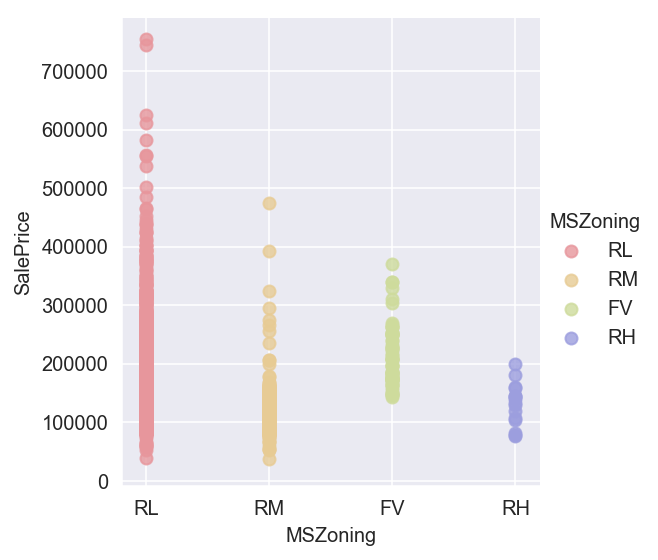

In [177]:
# investigate relationship between zoning and sale price
sns.lmplot(x = 'MSZoning', y = 'SalePrice', data = df, hue = 'MSZoning', \
           size = 4, fit_reg = False, palette = 'tab20b_r')

In [178]:
# investigate street type. 
df.Street.value_counts(dropna=False)

Pave    1444
Grvl       4
Name: Street, dtype: int64

In [179]:
# only 4 are gravel. drop as this variance too low.
dropcol(df,'Street')

C:\Users\schen24\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


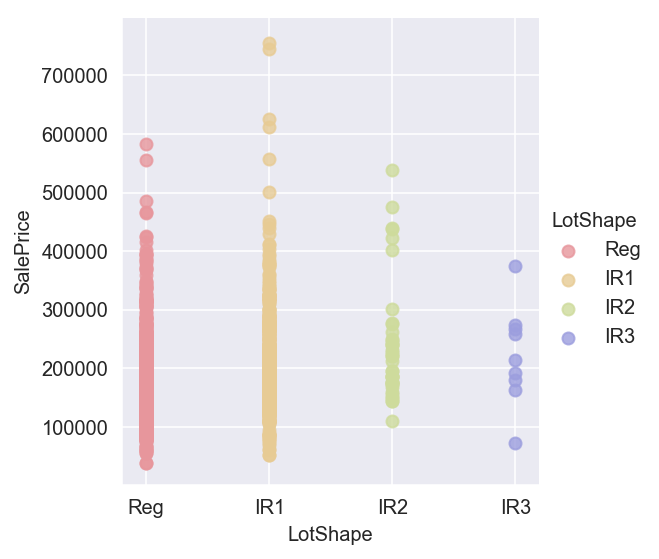

In [180]:
# investigate relationship between lotshape and sale price
sns.lmplot(x = 'LotShape', y = 'SalePrice', data = df, hue = 'LotShape', \
           size = 4, fit_reg = False, palette = 'tab20b_r')

In [181]:
# investigate land contour
df.groupby('LandContour').size()

LandContour
Bnk      60
HLS      49
Low      34
Lvl    1305
dtype: int64

C:\Users\schen24\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


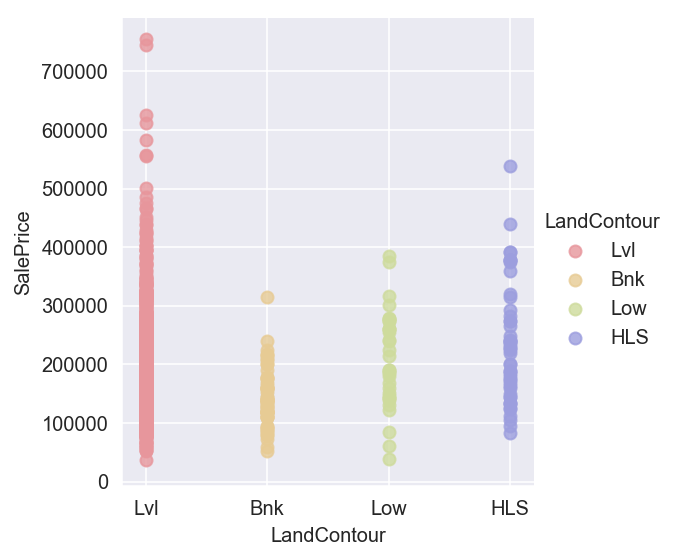

In [182]:
sns.lmplot(x = 'LandContour', y = 'SalePrice', data = df, hue = 'LandContour', \
           size = 4, fit_reg = False, palette = 'tab20b_r')

In [183]:
# there does seem to be a relationship between landcontour sale px, with bnk commanding lowest and lvl highest. 
# classify as ordinal
df['LandContour']= df['LandContour'].map({'Lvl':4, 'Bnk':1, 'HLS':3, 'Low': 2}).astype(int)

In [184]:
# investigate utilities
df.groupby('Utilities').size()

Utilities
AllPub    1447
NoSeWa       1
dtype: int64

In [185]:
# only 1 'nosewa', compared to 1449 'allpub'. no point using this variable. 
dropcol(df, 'Utilities')

In [186]:
# investigate lotconfig
df.groupby('LotConfig').size()

LotConfig
Corner      260
CulDSac      94
FR2          47
FR3           4
Inside     1043
dtype: int64

C:\Users\schen24\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


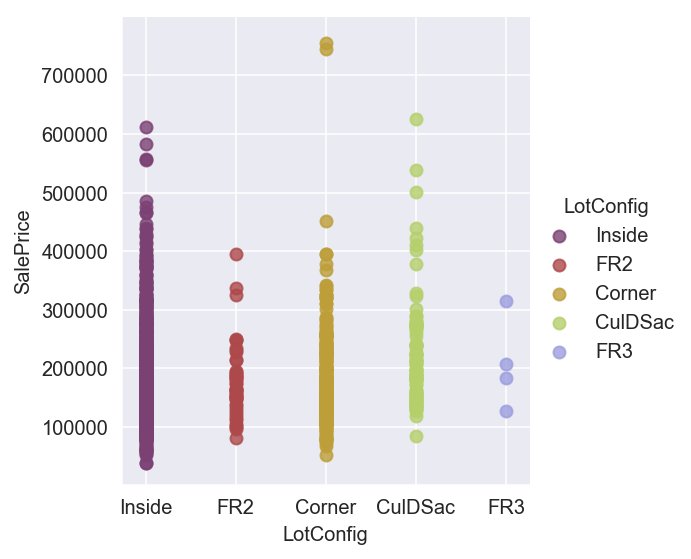

In [187]:
sns.lmplot(x = 'LotConfig', y = 'SalePrice', data = df, hue = 'LotConfig', \
           size = 4, fit_reg = False, palette = 'tab20b_r')

In [188]:
#combine 2and 3side frontage together since 3side frontage count is small.Categorical
df.LotConfig = df.LotConfig.replace('FR2', 'FR')
df.LotConfig = df.LotConfig.replace('FR3', 'FR')

In [189]:
# investigate landslope
df.groupby('LandSlope').size()

LandSlope
Gtl    1373
Mod      62
Sev      13
dtype: int64

C:\Users\schen24\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


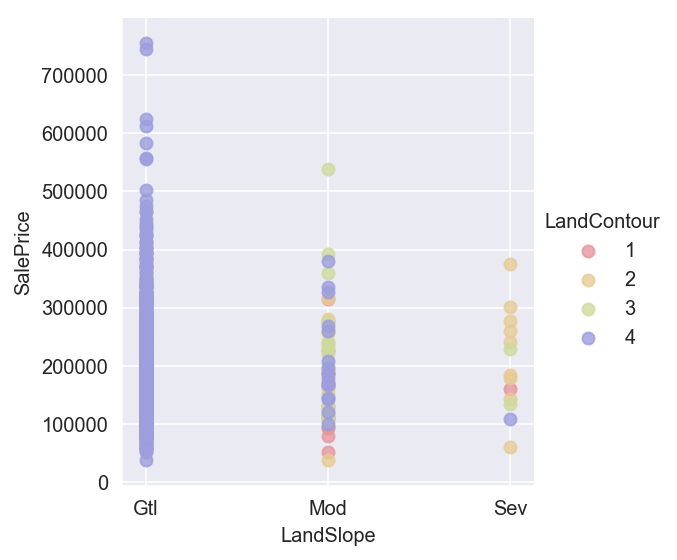

In [190]:
sns.lmplot(x = 'LandSlope', y = 'SalePrice', data = df, hue = 'LandContour', \
           size = 4, fit_reg = False, palette = 'tab20b_r')

In [191]:
# there appears to be an ordinal relationship between landslope and saleprice
# convert gentle = 3, moderate = 2, severe = 1
df['LandSlope']= df['LandSlope'].map({'Gtl':3, 'Mod':2, 'Sev':1}).astype(int)

In [192]:
#neighbourhood... what to do....

dict = {'Blmngtn': 'Bloomington Heights', 'Blueste':'Bluestem', 'BrDale':'Briardale', \
        'BrkSide':'Brookside', 'ClearCr':'Clear Creek', 'CollgCr':'College Creek', 'Crawfor':'Crawford',\
        'Edwards':'Edwards', 'Gilbert':'Gilbert', 'IDOTRR':'Iowa DOT and Rail Road', \
        'MeadowV':'Meadow Village', 'Mitchel':'Mitchell', 'Names':'North Ames', 'NoRidge':'Northridge',\
        'NPkVill':'Northpark Villa', 'NridgHt':'Northridge Heights', 'NWAmes': 'Northwest Ames', \
        'OldTown': 'Old Town', 'SWISU':'South and West of Iowa State University', 'Sawyer':'Sawyer', \
        'SawyerW':'Sawyer West', 'Somerst':'Somerset', 'StoneBr':'Stone Brook', \
        'Timber':'Timberland', 'Veenker':'Veenker'}
dict.values()

dict_values(['Bloomington Heights', 'Bluestem', 'Briardale', 'Brookside', 'Clear Creek', 'College Creek', 'Crawford', 'Edwards', 'Gilbert', 'Iowa DOT and Rail Road', 'Meadow Village', 'Mitchell', 'North Ames', 'Northridge', 'Northpark Villa', 'Northridge Heights', 'Northwest Ames', 'Old Town', 'South and West of Iowa State University', 'Sawyer', 'Sawyer West', 'Somerset', 'Stone Brook', 'Timberland', 'Veenker'])

C:\Users\schen24\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


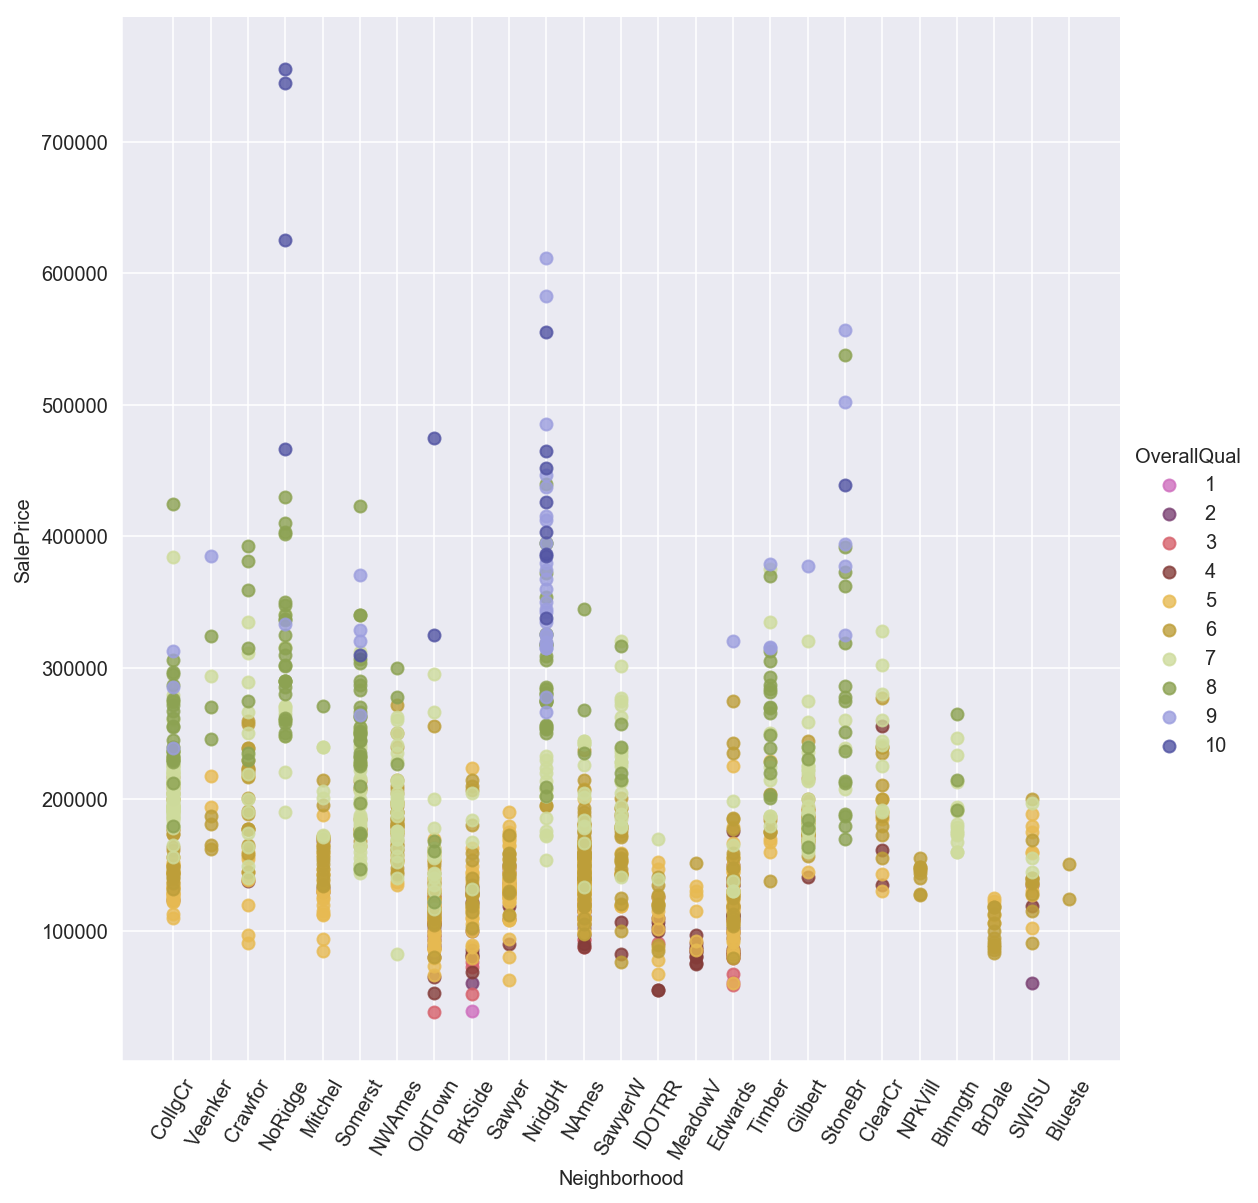

In [193]:
# investigate relationship between neighbourhoods, overall quality and sale price
g = sns.lmplot(x = 'Neighborhood', y = 'SalePrice', data = df, hue = 'OverallQual', \
           size = 8, fit_reg = False, palette = 'tab20b_r')
g.set_xticklabels(rotation=60)

In [194]:
# something's up with northridge, northride hts, and stoneBr! 
# also note that the most expensive houses tend to be of very high quality (to keep in mind for Q2)

C:\Users\schen24\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


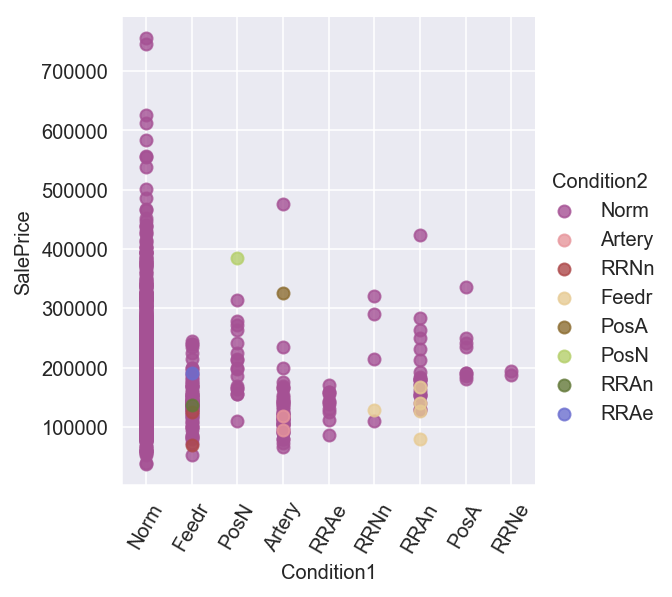

In [195]:
# examine condition 1 and 2
g = sns.lmplot(x = 'Condition1', y = 'SalePrice', data = df, hue = 'Condition2', \
           size = 4, fit_reg = False, palette = 'tab20b_r')
g.set_xticklabels(rotation=60)

In [196]:
#simplify features - RR for all railroads, Rd for Roads, Pos for positive factors and Norm for normal.
print(df.Condition1.unique())
condition = {'Artery':'Rd', 'Feedr': 'Rd','Norm': 'Norm', 'PosN':'Pos', 'PosA':'Pos', \
            'RRAe':'RR', 'RRNn':'RR', 'RRAn':'RR', 'RRNe': 'RR'}
df['Condition1'] = df['Condition1'].map(condition).astype(str)
df['Condition2'] = df['Condition2'].map(condition).astype(str)
print(df.Condition1.unique())
print(df.Condition2.unique())

['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
['Norm' 'Rd' 'Pos' 'RR']
['Norm' 'Rd' 'RR' 'Pos']


In [197]:
#condition 1 and 2 should be combined because there is no order to condition 1 and 2. 
#according to NcR, combination with replacement is (n+k-1)!/(k!(n-k)!) = 10 which is better than the n x n = 16 we'd 
# get by direct multiplication.
df['Condition'] = df['Condition1']+df['Condition2']

In [198]:
combos = np.array(df.Condition1.unique())+np.array(df.Condition2.unique()).reshape(-1,1)

In [199]:
combos

array([['NormNorm', 'RdNorm', 'PosNorm', 'RRNorm'],
       ['NormRd', 'RdRd', 'PosRd', 'RRRd'],
       ['NormRR', 'RdRR', 'PosRR', 'RRRR'],
       ['NormPos', 'RdPos', 'PosPos', 'RRPos']], dtype=object)

In [200]:
df['Condition'] = df['Condition'].map({'NormNorm': 'NormNorm', 'RdNorm':'RdNorm', 'PosNorm':'PosNorm', 'RRNorm':'RRNorm',\
                                      'NormRd': 'RdNorm', 'RdRd':'RdRd', 'PosRd':'PosRd', 'RRRd':'RRRd',\
                                      'NormRR':'RRNorm', 'RdRR':'RRRd' , 'PosRR':'PosRR', 'RRRR':'RRRR',\
                                      'NormPos':'PosNorm' , 'RdPos': 'PosRd', 'PosPos':'PosPos', 'RRPos':'PosRR'})

In [201]:
#categorical 
df.Condition.value_counts()

NormNorm    1252
RdNorm       119
RRNorm        39
PosNorm       25
RRRd           9
RdRd           2
PosRd          1
PosPos         1
Name: Condition, dtype: int64

C:\Users\schen24\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


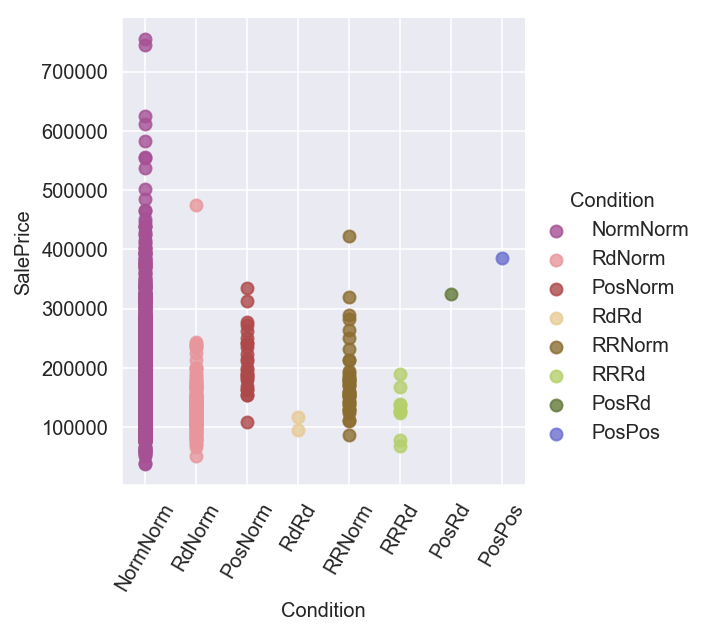

In [202]:
g = sns.lmplot(x = 'Condition', y = 'SalePrice', data = df, hue = 'Condition', \
           size = 4, fit_reg = False, palette = 'tab20b_r')
g.set_xticklabels(rotation=60)

In [203]:
#since counts are insignificant for RRRd = 9, RdRd=2 , PosPos =1,  PosRd= 1, add RdRd to RdNorm and Pos factors to PosNorm.
df.Condition = df['Condition'].replace('RRRd','RdNorm')
df.Condition = df['Condition'].replace('RdRd','RdNorm')
df.Condition = df['Condition'].replace('PosRd','PosNorm')
df.Condition = df['Condition'].replace('PosPos','PosNorm')
df.Condition.unique()

array(['NormNorm', 'RdNorm', 'PosNorm', 'RRNorm'], dtype=object)

In [204]:
dropcol(df, ['Condition1', 'Condition2'])

C:\Users\schen24\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


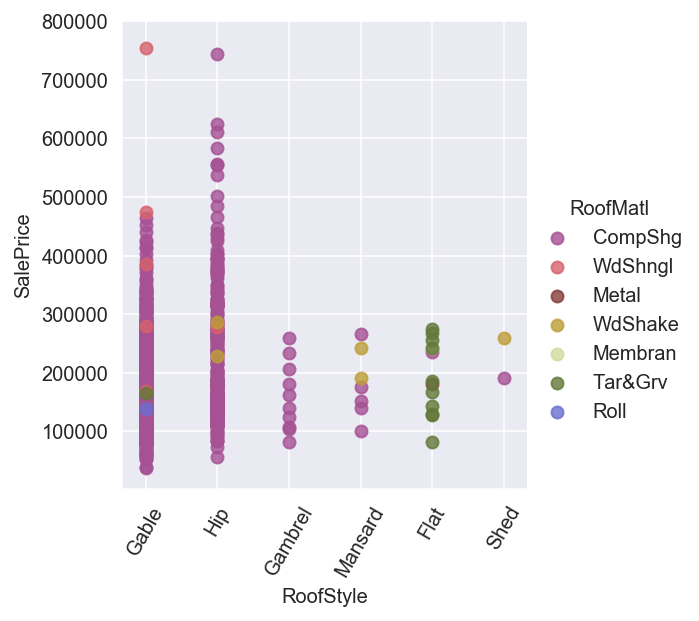

In [205]:
# Roofstyle
g = sns.lmplot(x = 'RoofStyle', y = 'SalePrice', data = df, hue = 'RoofMatl', \
           size = 4, fit_reg = False, palette = 'tab20b_r')
g.set_xticklabels(rotation=60)

In [206]:
# there isn't much variation for gambrel, mansard, flat and shed, so combine into 'other'
df['RoofStyle'] = df['RoofStyle'].map({'Gable':'Gable', 'Hip':'Hip', 'Gambrel':'Other', 'Mansard':'Other',\
                                       'Flat':'Other', 'Shed':'Other'})

In [207]:
df.RoofMatl.value_counts(dropna=False)

CompShg    1423
Tar&Grv      11
WdShngl       6
WdShake       5
Metal         1
Membran       1
Roll          1
Name: RoofMatl, dtype: int64

C:\Users\schen24\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


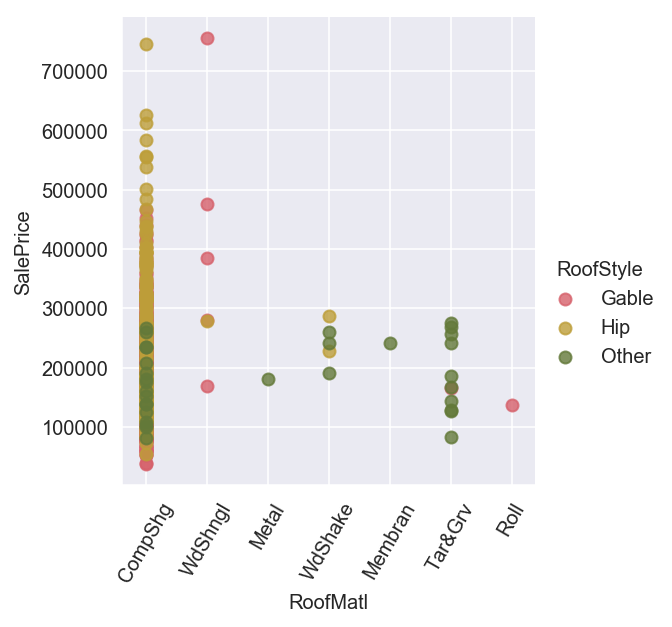

In [208]:
g = sns.lmplot(x = 'RoofMatl', y = 'SalePrice', data = df, hue = 'RoofStyle', \
           size = 4, fit_reg = False, palette = 'tab20b_r')
g.set_xticklabels(rotation=60)

In [209]:
# shingle related roofs seem to command higher prices. combine all shingle types =1 and combine all others under 'Other' = 0
# rename column as well
df.rename(columns={'RoofMatl' : 'RoofShingle'},inplace=True)

In [210]:
df['RoofShingle'] = df['RoofShingle'].map({'CompShg':1, 'WdShngl':1, 'Metal':0, 'WdShake':0, 'Membran':0, 'Tar&Grv':0,
       'Roll':0}).astype(float)

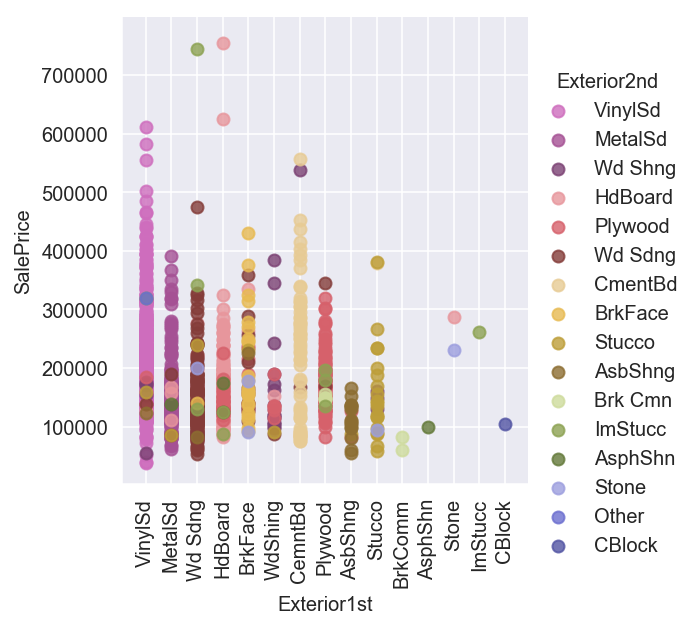

In [211]:
#Exterior1st, Exterior2nd
g = sns.lmplot(x = 'Exterior1st', y = 'SalePrice', data = df, hue = 'Exterior2nd', \
           height = 4, fit_reg = False, palette = 'tab20b_r')
g.set_xticklabels(rotation=90)

In [212]:
print(df.Exterior1st.isnull().sum())
print(df.Exterior2nd.isnull().sum())

0
0


In [213]:
# 85% of exterior1's match exterior2's, and as can be seen from graph above, the remaining 15% do not contribute 
# that much to higher prices. therefore use exterior1 values.
print(sum(df.Exterior1st[df.Exterior1st==df.Exterior2nd].value_counts()/len(df.Exterior1st)))

0.8522099447513813


In [214]:
df.Exterior1st.value_counts()

VinylSd    515
HdBoard    222
MetalSd    215
Wd Sdng    204
Plywood    107
CemntBd     60
BrkFace     49
WdShing     26
Stucco      24
AsbShng     19
BrkComm      2
Stone        2
AsphShn      1
CBlock       1
ImStucc      1
Name: Exterior1st, dtype: int64

In [215]:
# change bottom 7 types to 'other' as counts too small and not very expensive. 
other = list(df.Exterior1st.value_counts().index[-7:])
other

['Stucco', 'AsbShng', 'BrkComm', 'Stone', 'AsphShn', 'CBlock', 'ImStucc']

In [216]:
df['Exterior1st'] = np.where(df['Exterior1st'].isin(other), 'Other', df['Exterior1st'])

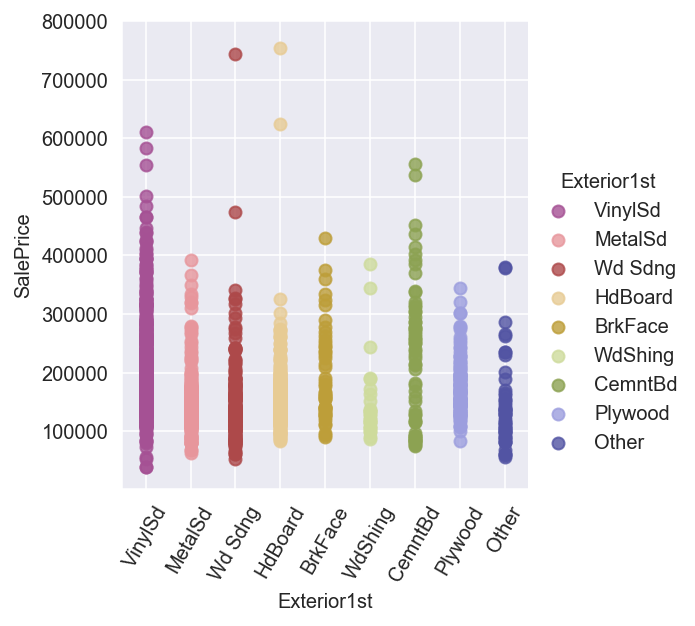

In [217]:
g = sns.lmplot(x = 'Exterior1st', y = 'SalePrice', data = df, hue = 'Exterior1st', \
           height = 4, fit_reg = False, palette = 'tab20b_r')
g.set_xticklabels(rotation=60)

In [218]:
dropcol(df, 'Exterior2nd')

In [219]:
#MasVnrType
df.MasVnrType.value_counts(dropna=False)

None       854
BrkFace    445
Stone      126
BrkCmn      15
NaN          8
Name: MasVnrType, dtype: int64

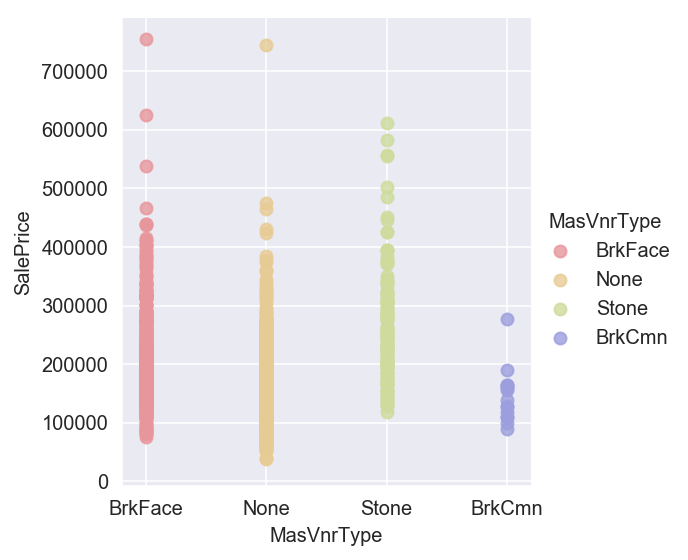

In [220]:
df.MasVnrType.fillna('None', inplace=True)
df.MasVnrArea.fillna(0, inplace=True)
sns.lmplot(x = 'MasVnrType', y = 'SalePrice', data = df, hue = 'MasVnrType', \
           height = 4, fit_reg = False, palette = 'tab20b_r')

In [221]:
# merge all brick types, as prices of brick common are within brick face price range.
df['MasVnrType'] = np.where((df['MasVnrType']=='BrkFace') | (df['MasVnrType'] == 'BrkCmn'), 'Brick', df['MasVnrType'])

In [222]:
# Foundation
df.Foundation.value_counts(dropna=False)

PConc     645
CBlock    627
BrkTil    144
Slab       24
Stone       5
Wood        3
Name: Foundation, dtype: int64

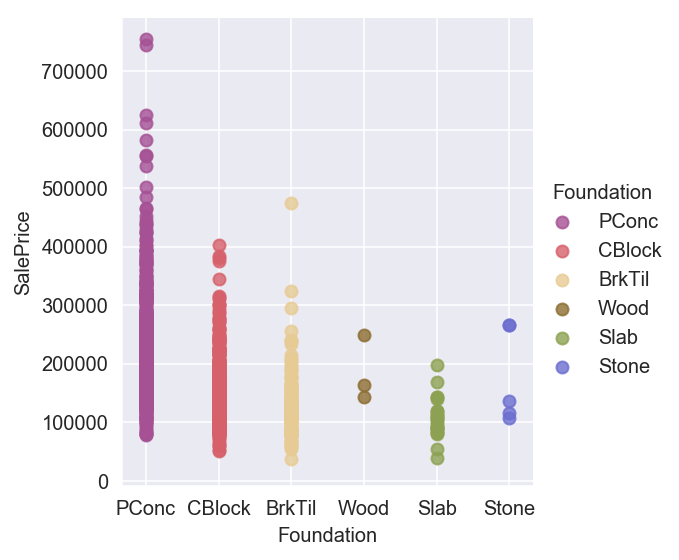

In [223]:
sns.lmplot(x = 'Foundation', y = 'SalePrice', data = df, hue = 'Foundation', \
           height = 4, fit_reg = False, palette = 'tab20b_r')

In [224]:
# slab, stone and wood are small in number and have low sale prices. combine into 'other' bucket
df.Foundation = df.Foundation.map({'PConc':'PConc' , 'CBlock':'CBlock', 'BrkTil':'BrkTil',\
                                   'Wood':'Other', 'Slab':'Other', 'Stone':'Other'})

In [225]:
qual = {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1, np.nan:0}

In [226]:
quality = ['ExterQual', 'ExterCond', 'BsmtHeight','BsmtCond','HeatingQC','KitchenQual','GarageQual','GarageCond',\
           'FireplaceQu']

In [227]:
# convert graded features into integers
for x in quality:
    df[x]= df[x].map(qual).astype(float)

In [228]:
# investigate paved drive
df.groupby('PavedDrive').size()

PavedDrive
N      85
P      30
Y    1333
dtype: int64

In [229]:
# separate paved(Y) = 1 from partially paved (P) and Unpaved(N) = 0
df['PavedDrive']= df['PavedDrive'].map({'Y':1, 'N':0, 'P':0}).astype(int)

In [230]:
# investigate basement exposure
df.groupby('BsmtExposure').size()

BsmtExposure
Av    219
Gd    132
Mn    112
No    947
dtype: int64

In [231]:
# change gradings to numbers
df['BsmtExposure']= df['BsmtExposure'].map({'Gd':3, 'Av': 2, 'Mn':1, 'No':0, np.nan: 0}).astype(int)

In [232]:
# investigate basement rating
df.BsmtFinType1.value_counts(dropna=False)

Unf    424
GLQ    416
ALQ    220
BLQ    147
Rec    130
LwQ     74
NaN     37
Name: BsmtFinType1, dtype: int64

In [233]:
df.BsmtFinType2.value_counts(dropna=False)

Unf    1244
Rec      54
LwQ      46
NaN      38
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64

In [234]:
#these are ordinals, so assign an ordinal value, based on quality. Nan = 0, Unf = 1, Low...high
df['BsmtFinType1']= df['BsmtFinType1'].map({'Unf':1, 'BLQ': 2, 'LwQ':2, 'Rec':3, np.nan: 0, \
                                           'ALQ': 3, 'GLQ':4}).astype(float)
df['BsmtFinType2']= df['BsmtFinType2'].map({'Unf':1, 'BLQ': 2, 'LwQ':2, 'Rec':3, np.nan: 0, \
                                           'ALQ': 3, 'GLQ':4}).astype(float)

In [235]:
# add score to get new column, 'BsmtFinType'
df['BsmtFinType'] = df['BsmtFinType1']+df['BsmtFinType2']

In [236]:
dropcol(df, ['BsmtFinType2','BsmtFinType1' ])

In [237]:
# investigate heating
df.groupby('Heating').size()

Heating
Floor       1
GasA     1417
GasW       17
Grav        7
OthW        2
Wall        4
dtype: int64

In [238]:
# drop heating. as Gas types dominate all the others
dropcol(df, 'Heating')

In [239]:
# convert central A/C to integers
df['CentralAir'] = df['CentralAir'].map({'Y': 1, 'N':0}).astype(int)

In [240]:
# functional
df.Functional.value_counts(dropna=False)

Typ     1348
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64

In [241]:
# ordinal - group into 5 categories
df.Functional = df.Functional.map({'Typ': 5, 'Min1': 4,'Min2': 4, 'Mod':3, 'Maj1':2, 'Maj2':2, 'Sev':1})

In [242]:
df.GarageType.unique()

array(['Attchd', 'Detchd', 'BuiltIn', 'CarPort', nan, 'Basment', '2Types'],
      dtype=object)

In [243]:
df.GarageType.fillna('None', inplace=True)
df.GarageType.value_counts(dropna=False)

Attchd     869
Detchd     381
BuiltIn     87
None        79
Basment     18
CarPort      8
2Types       6
Name: GarageType, dtype: int64

In [244]:
df.GarageFinish.value_counts(dropna=False)

Unf    600
RFn    419
Fin    350
NaN     79
Name: GarageFinish, dtype: int64

In [245]:
df.GarageFinish = df.GarageFinish.map({'Fin':3, 'RFn':2, 'Unf':1, np.nan:0})

In [246]:
df['GarageYrBlt'].value_counts(dropna=False)
df['GarageYrBlt'].fillna(0, inplace=True)

In [247]:
df.Fence.value_counts(dropna=False)

NaN      1170
MnPrv     155
GdPrv      59
GdWo       53
MnWw       11
Name: Fence, dtype: int64

In [248]:
df.Fence.fillna('None', inplace=True)

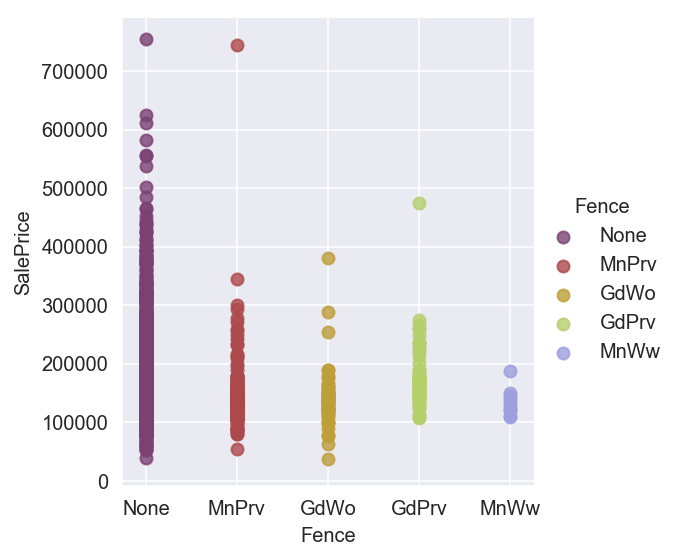

In [249]:
sns.lmplot(x = 'Fence', y = 'SalePrice', data = df, hue = 'Fence', \
           height = 4, fit_reg = False, palette = 'tab20b_r')

In [250]:
# unfenced houses seem to fetch higher prices than the rest. therefore code 1 for fenced and 0 for unfenced. 
df.Fence = np.where(df.Fence=='None', 0, 1)

In [251]:
df.SaleType.value_counts(dropna=False)

WD       1261
New       120
COD        41
ConLD       7
ConLw       5
ConLI       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

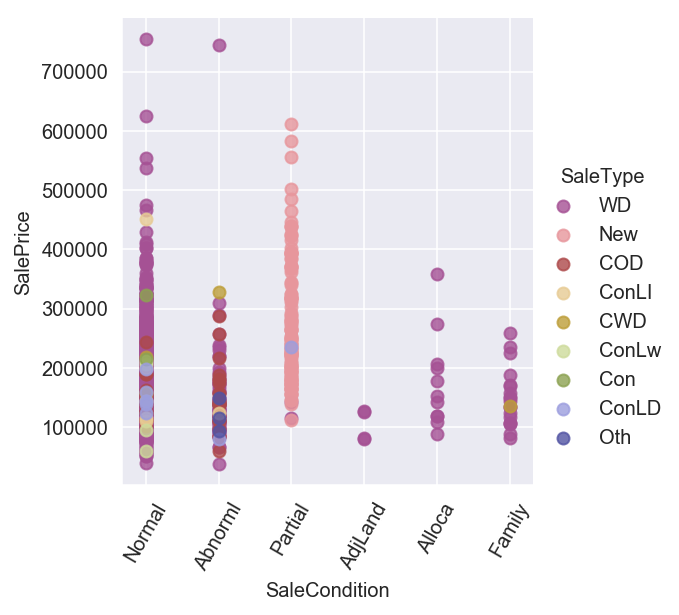

In [252]:
g = sns.lmplot(x = 'SaleCondition', y = 'SalePrice', data = df, hue = 'SaleType', \
           height = 4, fit_reg = False, palette = 'tab20b_r')
g.set_xticklabels(rotation=60)

In [253]:
# we're done with inspection. 
# now comes splitting the data

In [254]:
df.SaleCondition.value_counts()

Normal     1194
Partial     123
Abnorml      96
Family       20
Alloca       11
AdjLand       4
Name: SaleCondition, dtype: int64

In [255]:
# group categoricals for dummy creation 
categorical = list(df.select_dtypes(exclude='number').columns)

In [256]:
df.select_dtypes(exclude='number').sample(2)

,MSSubClass,MSZoning,LotShape,LotConfig,Neighborhood,RoofStyle,Exterior1st,MasVnrType,Foundation,GarageType,MoSold,SaleType,SaleCondition,Condition
1399,Sone,RL,Reg,Inside,SWISU,Gable,WdShing,None,BrkTil,Detchd,fall,WD,Normal,NormNorm
755,Stwo,FV,Reg,Inside,Somerst,Gable,MetalSd,Brick,PConc,Detchd,spring,WD,Normal,NormNorm


In [257]:
# fixed features of house
fixed = ['MSSubClass', 'LotFrontage', 'LotArea','LotShape','LandContour' , 'LotConfig',\
         'LandSlope','YearRemodAdd', 'MasVnrType','MasVnrArea', 'Foundation','BsmtHeight',\
         'BsmtExposure', 'TotalBsmtSF', 'GrLivArea','BedroomAbvGr','KitchenAbvGr',\
         'Fireplaces', 'GarageType','GarageYrBlt', 'GarageCars', 'GarageArea',  \
         'TotBathAbvGr', 'BsmtTotBath']

In [258]:
# factors attributed solely to location (house feature independent)
location = ['MSZoning','Neighborhood', 'Condition']
# universal features which apply to all split datasets
universal = ['MoSold', 'YrSold', 'SaleType', 'SaleCondition','SalePrice']

In [259]:
# variable features of house
variable = list(set(df) - set(fixed) - set(location)-set(universal))
print(variable)

['Functional', 'BsmtCond', 'OverallQual', 'CentralAir', 'GarageFinish', 'WoodDeckSF', 'FireplaceQu', 'ExterCond', 'BsmtFinType', 'OverallCond', 'HeatingQC', 'Electrical', 'GarageCond', 'OpenPorchSF', 'GarageQual', 'RoofShingle', 'RoofStyle', 'ExterQual', 'Fence', 'Exterior1st', 'PavedDrive', 'EnclosedPorch', 'KitchenQual']


In [260]:
fixeddummies = list(set(fixed).intersection(set(categorical)))
locationdummies = list(set(location).intersection(set(categorical)))
universaldummies = list(set(universal).intersection(set(categorical)))
variabledummies = list(set(variable).intersection(set(categorical)))
universaldummies

['SaleType', 'SaleCondition', 'MoSold']

In [261]:
# let's not make dummies for salecondition as it won't be used in Q1 and Q2 and is needed as Y var
# in Q3
universaldummies.remove('SaleCondition')
universaldummies

['SaleType', 'MoSold']

In [262]:
fixeddf = makedummies(df[fixed], fixeddummies)
locationdf = makedummies(df[location], locationdummies)
universaldf = makedummies(df[universal], universaldummies)
variabledf = makedummies(df[variable], variabledummies)

In [263]:
fixeddf.to_pickle("./fixeddf.pkl")
locationdf.to_pickle("./locationdf.pkl")
universaldf.to_pickle("./universaldf.pkl")
variabledf.to_pickle("./variabledf.pkl")